In [60]:
import warnings
# Set the warning filter to ignore all warnings
warnings.filterwarnings("ignore")

# Part 1 - Data Preparation

Let's import csv file, clean it and visualize data

In [2]:
import pandas as pd
import boto3, sagemaker, json

In [28]:
s3_path = f"s3://reinvent-demo-vsemaan/united-states-inflation-rate-cpi.csv"
!aws s3 cp $s3_path united-states-inflation-rate-cpi.csv

download: s3://reinvent-demo-vsemaan/united-states-inflation-rate-cpi.csv to ./united-states-inflation-rate-cpi.csv


In [29]:
# remove first 13 records from csv file
!sed -i '1,14d' united-states-inflation-rate-cpi.csv

In [32]:
# load the csv file into a dataframe
df = pd.read_csv("united-states-inflation-rate-cpi.csv")

# show fitst 5 records
df.head()

,Unnamed: 0,,.1,.2
0,date,Inflation Rate (%),Annual Change,
1,1960-12-31,1.458,NaN,NaN
2,1961-12-31,1.0707,-0.39,NaN
3,1962-12-31,1.1988,0.13,NaN
4,1963-12-31,1.2397,0.04,NaN


In [34]:
# remove the last column
df = df.iloc[:, :-1]
# show first 5 records
df.head()

,Unnamed: 0,,.1
0,date,Inflation Rate (%),Annual Change
1,1960-12-31,1.458,NaN
2,1961-12-31,1.0707,-0.39
3,1962-12-31,1.1988,0.13
4,1963-12-31,1.2397,0.04


In [39]:
# replace NaN with 0
df = df.fillna(0)
print(df)


    Unnamed: 0                                   .1
0         date   Inflation Rate (%)   Annual Change
1   1960-12-31                1.458               0
2   1961-12-31               1.0707           -0.39
3   1962-12-31               1.1988            0.13
4   1963-12-31               1.2397            0.04
..         ...                  ...             ...
59  2018-12-31               2.4426            0.31
60  2019-12-31               1.8122           -0.63
61  2020-12-31               1.2336           -0.58
62  2021-12-31               4.6979            3.46
63  2022-12-31               8.0028             3.3

[64 rows x 3 columns]


In [56]:
# use record 0 as column names
df.columns = df.iloc[0]

#remove fitst record
df = df.iloc[1:]

In [57]:
print(df)

0         date  Inflation Rate (%)  Annual Change
1   1960-12-31               1.458              0
2   1961-12-31              1.0707          -0.39
3   1962-12-31              1.1988           0.13
4   1963-12-31              1.2397           0.04
5   1964-12-31              1.2789           0.04
..         ...                 ...            ...
59  2018-12-31              2.4426           0.31
60  2019-12-31              1.8122          -0.63
61  2020-12-31              1.2336          -0.58
62  2021-12-31              4.6979           3.46
63  2022-12-31              8.0028            3.3

[63 rows x 3 columns]


In [ ]:
# desribe dataframe adn datatypes



/tmp/ipykernel_3856/724973645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[' Inflation Rate (%)'] = pd.to_numeric(df[' Inflation Rate (%)'])


<Axes: xlabel='date'>

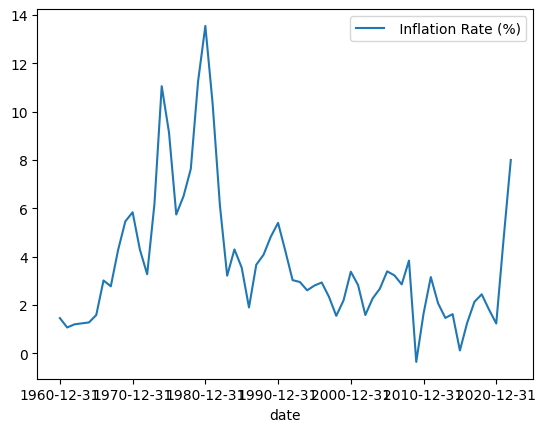

In [59]:
#set second column as numeric
df[' Inflation Rate (%)'] = pd.to_numeric(df[' Inflation Rate (%)'])
# build chart that shows second column on y and date on x
df.plot(x='date', y=' Inflation Rate (%)')

<Axes: xlabel='date'>

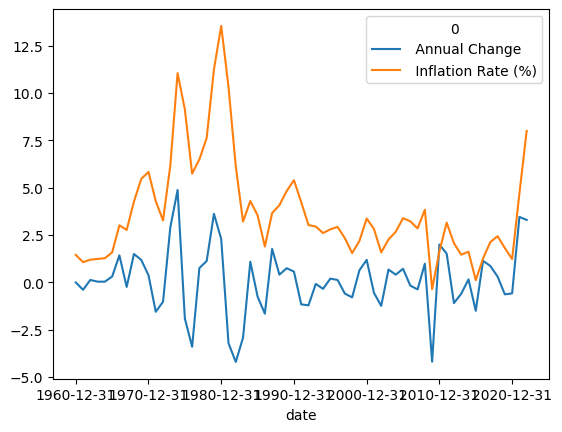

In [67]:
#set last column as numeric
df[' Annual Change'] = pd.to_numeric(df[' Annual Change'])

# build chart that shows Inflation Rate and Annual Change over time
df.plot(x='date', y=[' Annual Change', ' Inflation Rate (%)'])



In [68]:
# save the dataframe to a csv file
df.to_csv("inflation_rate-updated.csv", index=False)


In [69]:
# copy to s3 bucket
s3_path = "s3://reinvent-demo-vsemaan/inflation_rate-updated.csv"
!aws s3 cp inflation_rate-updated.csv $s3_path

upload: ./inflation_rate-updated.csv to s3://reinvent-demo-vsemaan/inflation_rate-updated.csv


# Part 2 - Deploy the model and invoke the endpoint

Let's deploy LLAMA2 model using SageMaker JumpStart

In [ ]:
# select a model 
model_id, model_version = "meta-textgeneration-llama-2-7b-f", "*"

In [ ]:
from sagemaker.jumpstart.model import JumpStartModel

model = JumpStartModel(model_id=model_id)
predictor = model.deploy()

In [70]:
#import dependencies
import time
import sagemaker, boto3, json
from sagemaker.session import Session
from sagemaker.model import Model
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base
from typing import Any, Dict, List, Optional
from langchain.embeddings import SagemakerEndpointEmbeddings
from langchain.llms.sagemaker_endpoint import ContentHandlerBase

In [71]:
from sagemaker.jumpstart.model import JumpStartModel
from langchain import SagemakerEndpoint

llm_endpoint_name = "meta-textgeneration-llama-2-7b-f-2023-10-12-21-36-42-788"

In [75]:
# define query format
def query_endpoint(payload):
    client = boto3.client("sagemaker-runtime")
    response = client.invoke_endpoint(
        EndpointName=llm_endpoint_name,
        ContentType="application/json",
        Body=json.dumps(payload),
        CustomAttributes="accept_eula=true",
    )
    response = response["Body"].read().decode("utf8")
    response = json.loads(response)
    return response

In [74]:
# make response human readable
def print_dialog(payload, response):
    dialog = payload["inputs"][0]
    for msg in dialog:
        print(f"{msg['role'].capitalize()}: {msg['content']}\n")
    print(f"> {response[0]['generation']['role'].capitalize()}: {response[0]['generation']['content']}")
    print("\n==================================\n")

In [79]:
payload = {
    "inputs": [[#import dependencies
import time
import sagemaker, boto3, json
from sagemaker.session import Session
from sagemaker.model import Model
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base
from typing import Any, Dict, List, Optional
from langchain.embeddings import SagemakerEndpointEmbeddings
from langchain.llms.sagemaker_endpoint import ContentHandlerBase
        {"role": "system", "content": "You are a helpful, respectful and honest assistant."},
        {"role": "user", "content": ""},
        
    ]],
    "parameters": {"max_new_tokens": 512, "top_p": 0.9, "temperature": 0.6}
}

In [80]:
response = query_endpoint(payload)
print_dialog(payload,response)

System: You are a helpful, respectful and honest assistant.

User: What was Inflation Rate in the US for year 2022?

> Assistant:  Thank you for asking! According to the Bureau of Labor Statistics (BLS), the inflation rate in the United States for the year 2022 was 7.0% (as of December 2022). This means that the prices of goods and services in the US increased by 7.0% compared to the previous year. It's important to keep track of inflation rates to understand how it can affect your personal finances and investments. If you have any further questions, feel free to ask!




# Part 3 - RAG workflow by combining the capabilities of Amazon Kendra with LLMs 



In [81]:
# use Kendra Retriever to get top 3 pieces
from langchain.retrievers import AmazonKendraRetriever
retriever = AmazonKendraRetriever(index_id="5bdc1703-32c6-4a55-854b-1907c62cb459",top_k=3)
aws_region = "us-west-2"

In [83]:
# Defining prompt
from langchain.prompts import PromptTemplate
prompt_template = """Use the following pieces of context to answer the question at the end. 

Context:  {context}

Question: {question}
Answer:"""

PROMPT = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

In [84]:
from langchain import PromptTemplate, SagemakerEndpoint
from langchain.llms.sagemaker_endpoint import LLMContentHandler
import json

class ContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs: dict) -> bytes:
        input_str = json.dumps({"inputs" : [[{"role" : "system",
        "content" : "You are an accurate information searching AI assitance."},
        {"role" : "user", "content" : prompt}]],
        "parameters" : {**model_kwargs}})
        return input_str.encode('utf-8')
    
    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json[0]["generation"]["content"]
    

parameters = {
    "max_new_tokens": 500,
    "top_p":0.5, 
    "temperature":0.01
}

content_handler = ContentHandler()

sm_llm = SagemakerEndpoint(
    endpoint_name = llm_endpoint_name, 
    region_name = aws_region, 
    model_kwargs = parameters,
    endpoint_kwargs={"CustomAttributes": 'accept_eula=true'},
    content_handler = content_handler,
)

In [85]:
from langchain.chains import RetrievalQA
import langchain

langchain.verbose = True
chain_type_kwargs = {"prompt": PROMPT}
qa = RetrievalQA.from_chain_type(llm=sm_llm, chain_type="stuff", retriever=retriever, chain_type_kwargs=chain_type_kwargs, return_source_documents=True)

In [86]:
query = "Inflation Rate in the US in 2022"
result = qa(query)



> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Use the following pieces of context to answer the question at the end. 

Context:  Document Title: U.S. Inflation Rate 1960-2023 | MacroTrends
Document Excerpt: 
Markets Market Indexes Precious Metals Energy Commodities Exchange Rates Interest Rates Futures Stock Research Top Stocks Stock Screener Top 100 Dividend Stocks Economy U.S. Economic Charts GDP by Country GDP Per Capita by Country Manufacturing by Country Debt to GDP Ratio by Country Global Metrics Topic Overview Largest Countries by Population U.S. States by Population U.S. and World Cities by Population U.S. Inflation Rate 1960-2023 Population Economy Trade Health Education Development Labor Force Environment Crime Immigration Other GDP GDP Growth Rate GDP Per Capita GNI GNI Per Capita Debt to GDP GNP Inflation Rate Economic Growth Manufacturing Inflation as measured by the consumer 

In [87]:
print(result['result'])

 According to the document, the inflation rate in the US in 2022 was 8.00%, which is an increase of 3.3% from 2021.


In [90]:
query = ""
result = qa(query)
print(result['result'])



> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Use the following pieces of context to answer the question at the end. 

Context:  Document Title: Starbucks-FY22-Annual-Report.pdf
Document Excerpt: 
Properties The material properties used by Starbucks in connection with its roasting, manufacturing, warehousing, distribution and corporate administrative operations, serving all segments, are as follows: Location Approximate Size in Square Feet Purpose York, PA 1,957,000 Roasting, warehousing and distribution Seattle, WA 1,145,000 Corporate administrative Minden, NV (Carson Valley) 1,080,000 Roasting, warehousing and distribution Lebanon, TN 680,000 Warehousing and distribution Kent, WA 510,000 Roasting and distribution Auburn, WA 491,000 Warehousing and distribution Shanghai, China 225,000 Corporate administrative We own most of our roasting facilities and lease the majority of our warehousing